In [ ]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
n_samples = 1000
noise = 0.1
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
X_tensor = torch.tensor(X, dtype=torch.float32)#.to(device)
y_tensor = torch.tensor(y, dtype=torch.long)#.to(device)

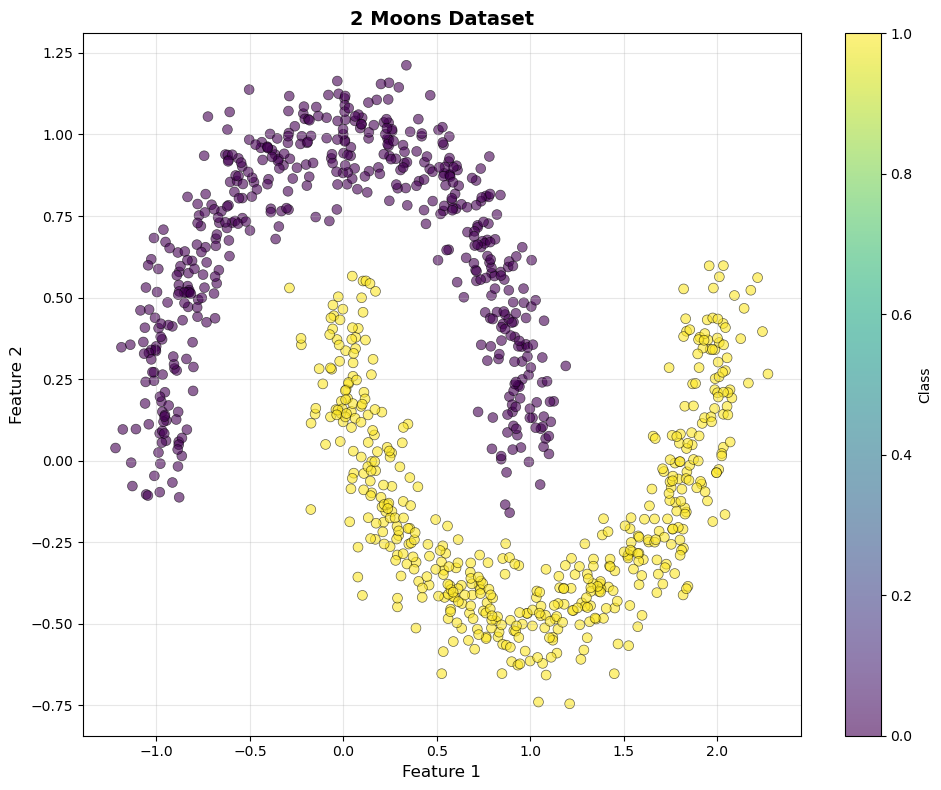

In [ ]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('2 Moons Dataset', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.ReLU(),
    nn.Sigmoid()
)#.to(device)

In [ ]:
y = model(X_tensor)
y = (y < 0.5).to(torch.int32)

/tmp/ipykernel_85233/1718290394.py:52: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(X_tensor[~correct_mask, 0], X_tensor[~correct_mask, 1],


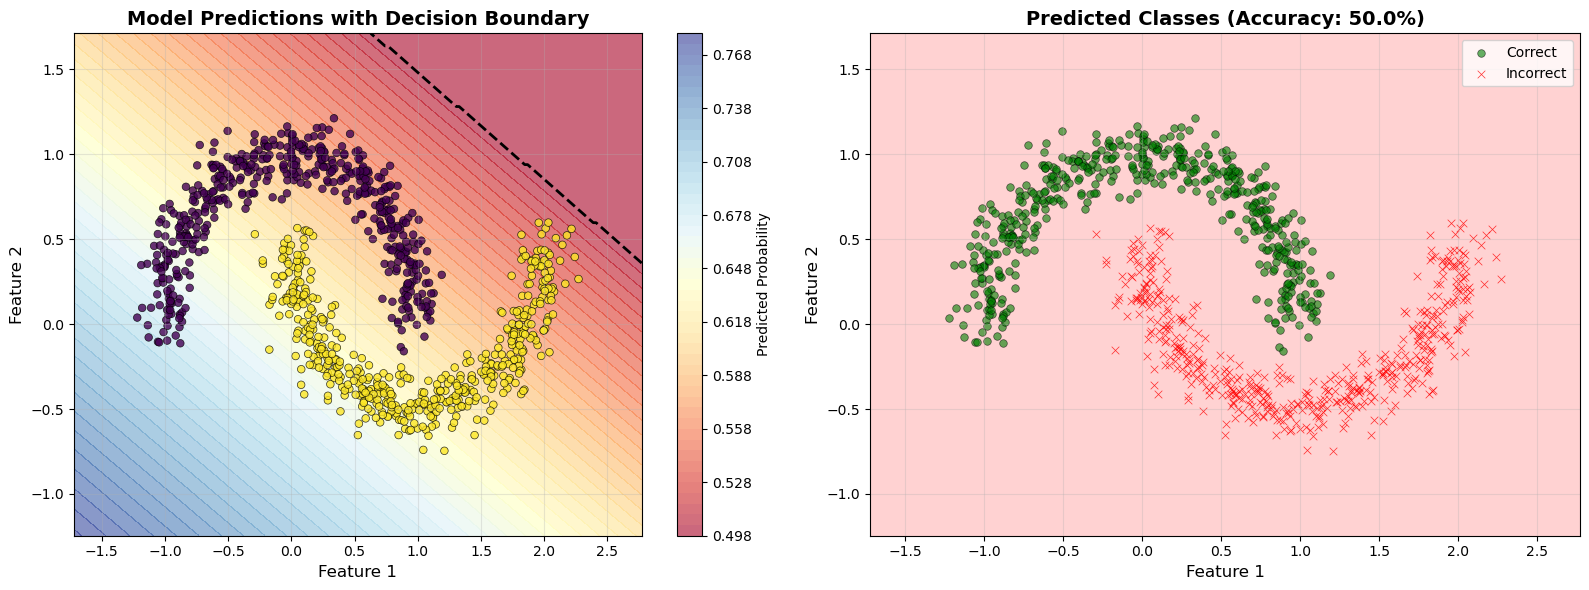

In [ ]:
# Plot model predictions with decision boundary
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get the data range for creating a mesh
x_min, x_max = X_tensor[:, 0].min() - 0.5, X_tensor[:, 0].max() + 0.5
y_min, y_max = X_tensor[:, 1].min() - 0.5, X_tensor[:, 1].max() + 0.5

# Create a mesh grid for decision boundary visualization
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

# Get model predictions on the grid
model.eval()
with torch.no_grad():
    grid_pred = model(grid_points)
    grid_pred_binary = (grid_pred < 0.5).to(torch.int32).numpy()
    grid_pred_proba = grid_pred.numpy()

# Reshape for plotting
Z_binary = grid_pred_binary.reshape(xx.shape)
Z_proba = grid_pred_proba.reshape(xx.shape)

# Plot 1: Decision boundary with probability contours
ax1 = axes[0]
contour = ax1.contourf(xx, yy, Z_proba, levels=50, cmap='RdYlBu', alpha=0.6)
ax1.contour(xx, yy, Z_proba, levels=[0.5], colors='black', linewidths=2, linestyles='--')
scatter1 = ax1.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y_tensor, 
                       cmap='viridis', s=30, alpha=0.8, edgecolors='k', linewidth=0.5)
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('Model Predictions with Decision Boundary', fontsize=14, fontweight='bold')
plt.colorbar(contour, ax=ax1, label='Predicted Probability')
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted classes vs True classes
ax2 = axes[1]
# Get model predictions on actual data
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_tensor)
    y_pred = (y_pred_proba < 0.5).to(torch.int32).squeeze()

# Plot decision regions
ax2.contourf(xx, yy, Z_binary, levels=[-0.5, 0.5, 1.5], colors=['#FF6B6B', '#4ECDC4'], alpha=0.3)
ax2.contour(xx, yy, Z_binary, levels=[0.5], colors='black', linewidths=2)

# Plot points: correct predictions in green, incorrect in red
correct_mask = (y_pred.squeeze() == y_tensor)
ax2.scatter(X_tensor[correct_mask, 0], X_tensor[correct_mask, 1], 
           c='green', s=30, alpha=0.6, edgecolors='k', linewidth=0.5, label='Correct')
ax2.scatter(X_tensor[~correct_mask, 0], X_tensor[~correct_mask, 1], 
           c='red', s=30, alpha=0.8, edgecolors='k', linewidth=0.5, marker='x', label='Incorrect')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title(f'Predicted Classes (Accuracy: {(correct_mask.sum().item()/n_samples*100):.1f}%)', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()